# Show cases Testing with Concept Activation Vectors (TCAV) on Imagenet Dataset and GoogleNet model

This tutorial shows how to apply TCAV, a concept-based model interpretability algorithm, on a classification task using GoogleNet model and imagenet dataset.

More details about the approach can be found here:
https://arxiv.org/pdf/1711.11279.pdf

In order to use TCAV, we need to predefine a list of concepts that we want our predictions to be test against.

**Concepts** are human-understandable, high-level abstractions such as visually represented "stripes" in case of images or tokens such as "female" in case of text. Concepts are formatted and represented as input tensors and do not need to be part of the training or test datasets.

Concepts are incorporated into the importance score computations using Concept Activation Vectors (CAVs). Traditionally, CAVs train linear classifiers and learn decision boundaries between different concepts using the activations of predefined concepts in a NN layer as inputs to the classifier that we train. The vector that is orthogonal to learnt decision boundary and is pointing towards the direction of a concept is the CAV of that concept.

TCAV measures the importance of a concept for a prediction based on the directional sensitivity (derivatives) of a concept in Neural Network (NN) layers. For a given concept and layer it is obtained by **aggregating** the dot product between CAV for a given concept in a given layer and the gradients of model predictions w.r.t. given layer output. The aggregation can be performed based on either signs or magnitudes of the directional sensitivities of concepts across multiple examples belonging to a certain class. More details about the technique can be found in above mentioned papers.

**Note:** Before running this tutorial, please install the torchvision, numpy, scipy, sklearn, PIL, and matplotlib packages.




In [1]:
import numpy as np
import os, glob, sys

import matplotlib.pyplot as plt

from PIL import Image

from scipy.stats import ttest_ind

# ..........torch imports............
import torch
import torchvision

from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms

#.... Captum imports..................
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str


## Defining image related transformations and functions

Let's define image transformation function.

In [2]:
# Method to normalize an image to Imagenet mean and standard deviation
def transform(img):

    return transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )(img) 


Now let's define a few helper functions.

In [3]:
def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("RGB")
    return transform(img)


def load_image_tensors(class_name, root_path='/workspace/melanoma_isic_dataset/melanomas', transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')

    tensors = []
    for filename in filenames:
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img)
    
    return tensors


Defining a helper function to load predefined concepts. `assemble_concept` function reads the concepts using a directory path where the concepts are residing and constructs concept object.

In [4]:
def assemble_concept(name, id, concepts_path="/workspace/Explainability_Dermatology/biases/concepts"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)


Let's assemble concepts into Concept instances using Concept class and concept images stored in `concepts_path`. We will use these concepts later in our experiments. 
Below we define five concepts. Three out of five are related to image texture and patterns such as `striped`, `zigzagged` and `dotted`. The other two represent random concepts. Random concepts contain elements / images that are associated with various possible concepts. Distinct from those defined for `striped`, `zigzagged` and `dotted`.

Note that concepts should be created and stored under `data/tcav/image/concepts/` folder in advance. 

`striped`, `zigzagged` and `dotted` concepts can be found in broden dataset:  https://netdissect.csail.mit.edu/broden1_224, under `images/dtd` folder as also described here: https://github.com/tensorflow/tcav/tree/master/tcav/tcav_examples/image_models/imagenet. There are in total 120 images for each of the `striped`, `zigzagged` and `dotted` concepts.

Please, download those concept images and place under `striped`, `zigzagged` and `dotted` folders under `data/tcav/image/concepts/` folder accordingly.

Random type of concepts are uniformly sampled from imagenet dataset. More details on how to download and setup imagenet dataset can he found here:
https://github.com/tensorflow/tcav/tree/master/tcav/tcav_examples/image_models/imagenet

We will randomly sample 4 diffent sets of 120 random images from imagenet dataset. Note that these images should be distinct from concept and zebra images since the testing will be performed on zebra images.
Place random images under `random_0`, `random_1`, `random_2` and `random_3` folders under `data/tcav/image/concepts/` folder similar to `striped` concept.


In [5]:
concepts_path = "/workspace/Explainability_Dermatology/concepts" 


frame_concept = assemble_concept("frame", 0, concepts_path=concepts_path)
ruler_concept = assemble_concept("ruler", 1, concepts_path=concepts_path)
hair_dense_concept = assemble_concept("hair_dense", 2, concepts_path=concepts_path)
hair_short_concept = assemble_concept("hair_short", 3, concepts_path=concepts_path)
#other_concept = assemble_concept("other", 4, concepts_path=concepts_path) 

#dark_concept = assemble_concept("dark", 0, concepts_path=concepts_path)
#red_concept = assemble_concept("red", 1, concepts_path=concepts_path)
indicator_concept = assemble_concept("indicator", 4, concepts_path=concepts_path)
pen_concept = assemble_concept("pen", 5, concepts_path=concepts_path)
#small_concept = assemble_concept("small", 4, concepts_path=concepts_path)

random_0_concept = assemble_concept("random_0", 6, concepts_path=concepts_path)  # Clean/train/malignant
random_1_concept = assemble_concept("random_1", 7, concepts_path=concepts_path)  # Clean/train/ben
random_2_concept = assemble_concept("random_2", 8, concepts_path=concepts_path)

In [6]:
#for i, examples in enumerate(frame_concept.data_iter) 

Let\'s visualize some samples from those concepts

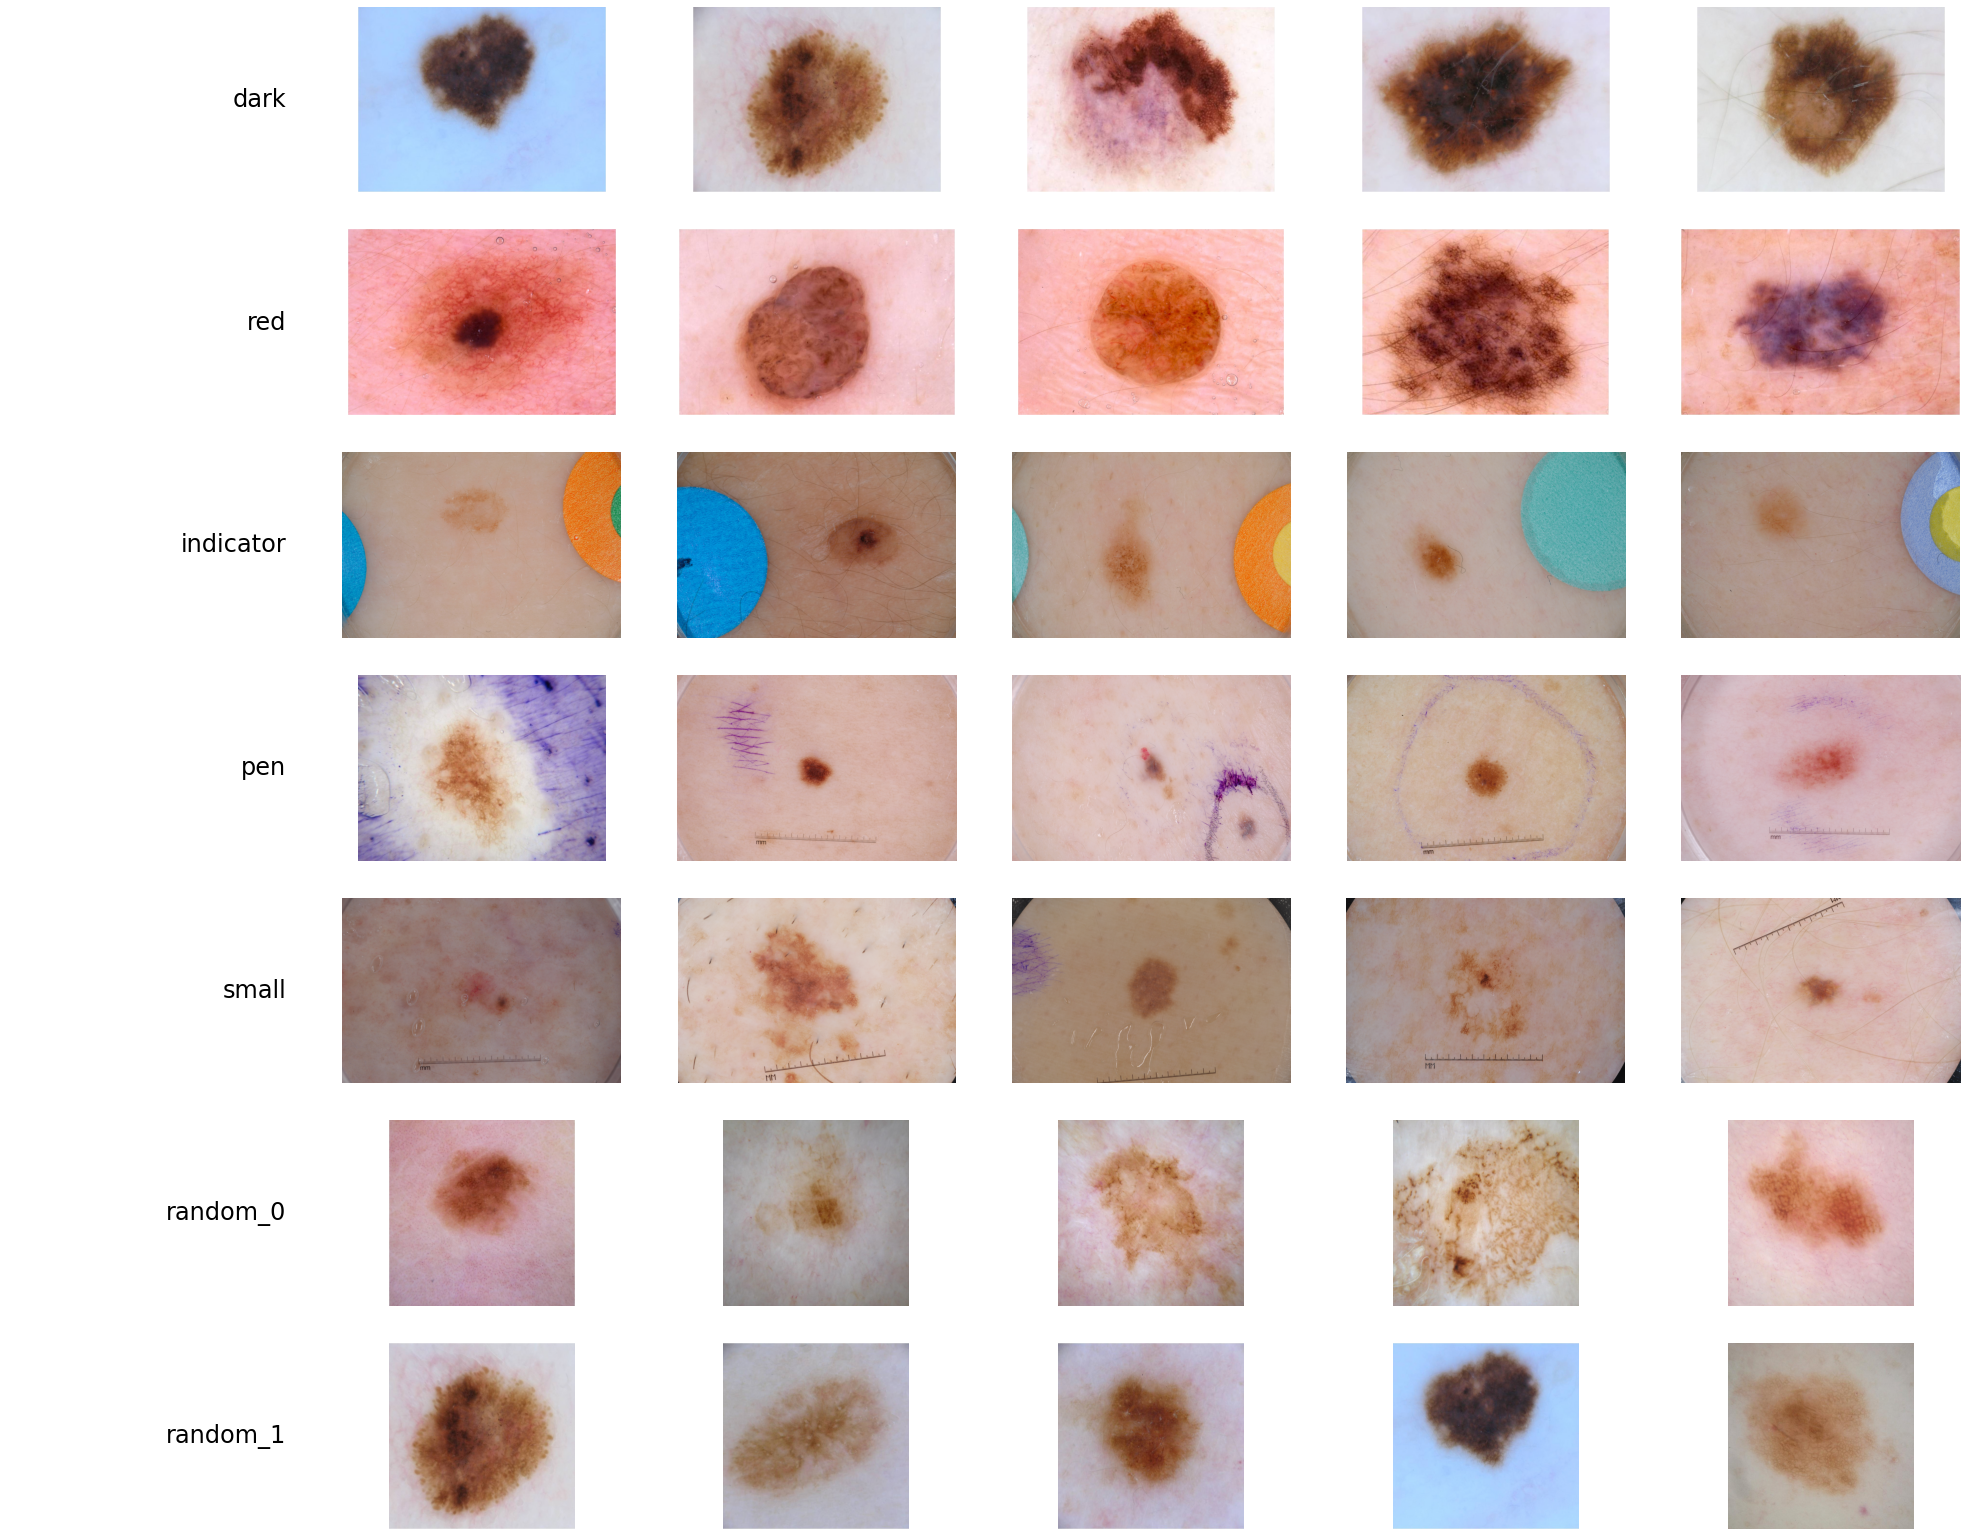

In [15]:
n_figs = 5
n_concepts = 7

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (35, 4 * n_concepts))

for c, concept in enumerate([dark_concept, red_concept, indicator_concept, pen_concept, small_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/" 
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')


## Defining GoogleNet Model

For this tutorial, we will load GoogleNet model and set in eval mode.

In [7]:
from efficientnet_pytorch import EfficientNet
from torchsummary import summary
import os, sys
sys.path.append('/workspace/stylegan2-ada-pytorch') 
from utils import Net 

# model = Net(arch = EfficientNet.from_pretrained('efficientnet-b2') ) #model.load_state_dict(torch.load('./stylegan2-ada-pytorch/CNN_trainings/melanoma_model_0_0.9225_16_12_train_reals+15melanoma.pth')) 
googlenet = torchvision.models.googlenet(pretrained=True)
#model = Net(arch = googlenet) 
#model.load_state_dict(torch.load('/workspace/stylegan2-ada-pytorch/training_classifiers_events/1_27/melanoma_model_0_0.9865_2022-01-27_googlenet.pth')) 

resnet = torchvision.models.resnet50(pretrained=True) # ./stylegan2-ada-pytorch/training_classifiers_events/1_27/melanoma_model_0_0.9836_2022-01-27_resnet50.pth
model = Net(arch = resnet)
model.load_state_dict(torch.load('/workspace/stylegan2-ada-pytorch/training_classifiers_events/1_27/melanoma_model_0_0.9836_2022-01-27_resnet50.pth')) 

model = model.eval()
# summary(model, (3,256,256))

# Computing TCAV Scores

Next, let's create TCAV class by passing the instance of EfficientNet model, a custom classifier and the list of layers where we would like to test the importance of concepts.

The custom classifier will be trained to learn classification boundaries between concepts. We offer a default implementation of Custom Classifier in captum library so that the users do not need to define it. Captum users, hoowever, are welcome to define their own classifers with any custom logic. CustomClassifier class extends abstract Classifier class and provides implementations for training workflow for the classifier and means to access trained weights and classes. Typically, this can be, but is not limited to a classier, from sklearn library. In this case CustomClassifier wraps `linear_model.SGDClassifier` algorithm from sklearn library.

In [8]:
layers=['arch.layer2', "arch.layer3", "arch.layer4"] #, 'arch._blocks[22]', 'arch._blocks[21]']

mytcav = TCAV(model=model, 
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))


/opt/conda/lib/python3.8/site-packages/captum/concept/_utils/classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


##### Defining experimantal sets for CAV

Then, lets create 2 experimental sets 

We will train a classifier for each experimental set that learns hyperplanes which separate the concepts in each experimental set from one another. This is especially interesting when later we want to perform two-sided statistical significance testing in order to confirm or reject the significance of a concept in a specific layer for predictions.

Now, let's load sample images. The goal is to test how sensitive model predictions are to predefined concepts such as 'frame' when predicting 'melanoma' class.



In [20]:
experimental_set_rand = [[frame_concept, random_1_concept], [indicator_concept,  random_1_concept], [ruler_concept,  random_1_concept],
                          [frame_concept, random_0_concept], [frame_concept, random_0_concept]  ]


In [9]:
# Load sample images from folder
melanomas_imgs = load_image_tensors('', transform=False)

Visualizing some of the images that we will use for making predictions and explaining those predictions by the means of concepts defined above.

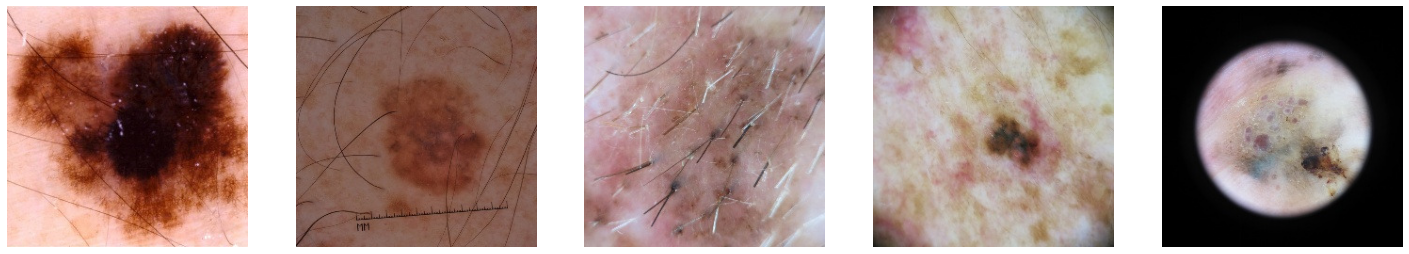

In [39]:
fig, axs = plt.subplots(1, 5, figsize = (25, 5))
axs[0].imshow(melanomas_imgs[40])
axs[1].imshow(melanomas_imgs[41])
axs[2].imshow(melanomas_imgs[34])
axs[3].imshow(melanomas_imgs[31])
axs[4].imshow(melanomas_imgs[30])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

plt.show()

Here we perform a transformation and convert the images into tensors, so that we can use them as inputs to NN model.

In [10]:
# Load sample images from folder
melanoma_tensors = torch.stack([transform(img) for img in melanomas_imgs[:250]]) 

In [21]:
#experimental_set_rand = [[dark_concept, random_0_concept], [indicator_concept,  random_0_concept],[red_concept,  random_0_concept],[small_concept,  random_0_concept], [pen_concept,  random_0_concept]]

tcav_scores_w_random = mytcav.interpret(inputs=melanoma_tensors,
                                        experimental_sets=experimental_set_rand,
                                        target=0,
                                        n_steps=5,
                                       )
tcav_scores_w_random

defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-7': defaultdict(None,
                         {'arch.layer2': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([1., 0.])},
                          'arch.layer3': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([1., 0.])},
                          'arch.layer4': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([1., 0.])}}),
             '4-7': defaultdict(None,
                         {'arch.layer2': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([0., 1.])},
                          'arch.layer3': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([0., 1.])},
                          'arch.layer4': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([0., 1.])}}),
             '1-7': defaultdict(None,

Auxiliary functions for visualizing of TCAV scores.

In [11]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['magnitude'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

Let's use above defined auxilary functions and visualize tcav scores below.

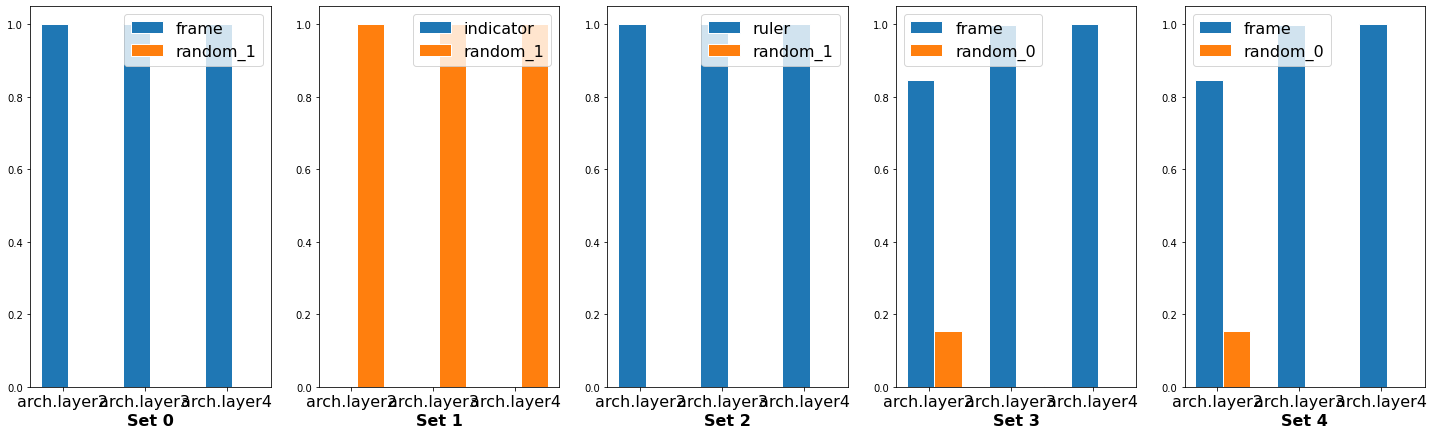

In [22]:

plot_tcav_scores(experimental_set_rand, tcav_scores_w_random)


From the plot above we observe that the images that are predicted as `melanoma` by the model are very sensitive  to `frame` concept as opposed to any random concept. 

Now, let's compute TCAV scores for a different experimental set that contains three different specific concepts such as `frame`, `ruler` and `short hair`.

In [16]:
experimental_set_frame_ruler_shorthair = [[frame_concept, ruler_concept, pen_concept]]


In [17]:

tcav_scores_f_r_h = mytcav.interpret(inputs=melanoma_tensors,
                                         experimental_sets=experimental_set_frame_ruler_shorthair,
                                         target=0,
                                         n_steps=5)


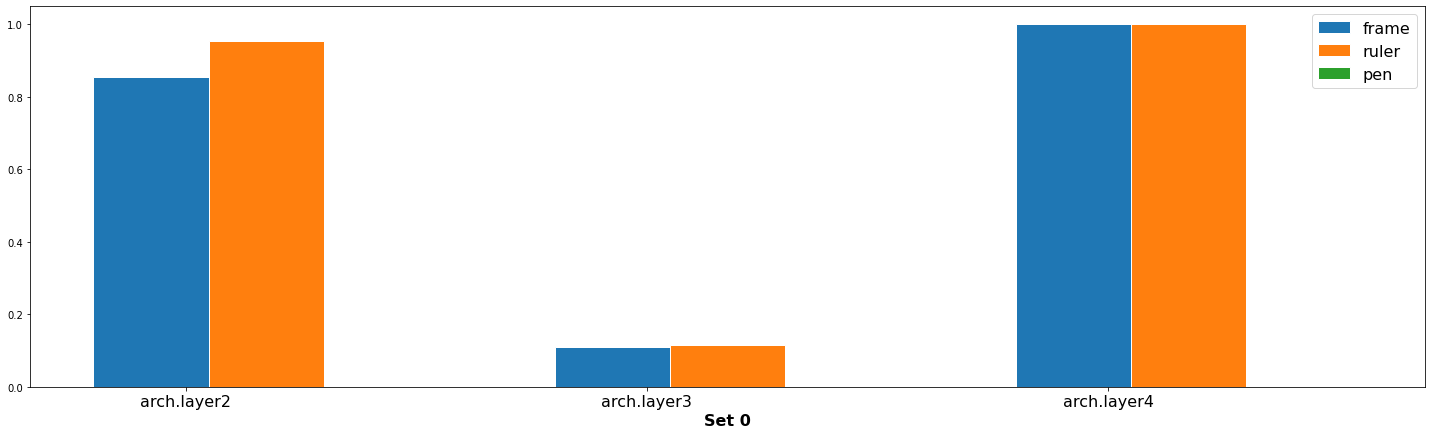

In [18]:
plot_tcav_scores(experimental_set_frame_ruler_shorthair, tcav_scores_f_r_h ) 

We observe that `frame` concept has very high TCAV compared to `ruler` and `hair short`. This means that the `ruler` concept is an essential concept in predicting `melanoma`.  

# Statistical significance testing of concepts

In order to convince ourselves that our concepts truly explain our predictions, we conduct statistical significance tests on TCAV scores by constructing a number of experimental sets. In this case we look into the `frame` concept and a number of random concepts.
If `frame` concept is truly important in predicting `melanoma` in the images that contain `melanomas`, then we will see consistent high TCAV scores for `frame` concept across all experimental sets as apposed to any other concept.

Each experimental set contains a random concept consisting of a number of random subsamples. In our case this allows us to estimate the robustness of TCAV scores by the means of numerous random concepts. 

Let's define those experimental sets in the cell below.


We will look into `frame`, and a number of random concepts drawn uniformly random from imagenet dataset.
```
concept_list = ['frame', 'random_0', 'random_1', 'random2', ... , 'random_n'], n is the number of concepts
```

Then, we will construct pairs of experimental sets that contain pairs of two concepts. In this case:
```
experimental_sets = [['frame', 'random_0'], ['frame', 'random_1'], ... , ['frame', 'random_n'], 
                    ['random_0', 'random_1'], ['random_0', 'random_2'], ... , ['random_0', 'random_n']]
```

In [20]:

n = 5

random_concepts = [assemble_concept('random_' + str(i+1), i+8, concepts_path) for i in range(1, n)]
print(random_concepts)

experimental_sets = [[frame_concept, random_1_concept]]
experimental_sets.extend([[frame_concept, random_concept] for random_concept in random_concepts])

experimental_sets.extend([[random_1_concept, random_concept_n] for random_concept_n in random_concepts])

experimental_sets

[Concept(9, 'random_2'), Concept(10, 'random_3'), Concept(11, 'random_4'), Concept(12, 'random_5')]


[[Concept(0, 'frame'), Concept(7, 'random_1')],
 [Concept(0, 'frame'), Concept(9, 'random_2')],
 [Concept(0, 'frame'), Concept(10, 'random_3')],
 [Concept(0, 'frame'), Concept(11, 'random_4')],
 [Concept(0, 'frame'), Concept(12, 'random_5')],
 [Concept(7, 'random_1'), Concept(9, 'random_2')],
 [Concept(7, 'random_1'), Concept(10, 'random_3')],
 [Concept(7, 'random_1'), Concept(11, 'random_4')],
 [Concept(7, 'random_1'), Concept(12, 'random_5')]]

In [19]:
del experimental_sets

Now, let's define a convenience function for assembling the experiments together as lists of Concept objects, creating and running the TCAV:

In addition, it is interesting to look into the p-values of statistical significance tests for each concept. We say, that we reject null hypothesis, if the p-value for concept's TCAV scores is smaller than 0.05. This indicates that the concept is important for model prediction.

We label concept populations as overlapping if p-value > 0.05 otherwise disjoint.

We now run the TCAV and obtain the scores:

In [13]:
# Run TCAV
scores = mytcav.interpret(melanoma_tensors, experimental_sets, 0, n_steps=5)
scores

defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-6': defaultdict(None,
                         {'arch.layer2': {'sign_count': tensor([0.7160, 0.2840]),
                           'magnitude': tensor([0.8474, 0.1526])},
                          'arch.layer3': {'sign_count': tensor([0.9880, 0.0120]),
                           'magnitude': tensor([9.9937e-01, 6.3307e-04])},
                          'arch.layer4': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([1., 0.])}}),
             '0-7': defaultdict(None,
                         {'arch.layer2': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([1., 0.])},
                          'arch.layer3': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([1., 0.])},
                          'arch.layer4': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([1., 0.])}}

We can present the distribution of tcav scores using boxplots and the p-values indicating whether TCAV scores of those concepts are overlapping or disjoint.

KeyError: 'arch.layer4'

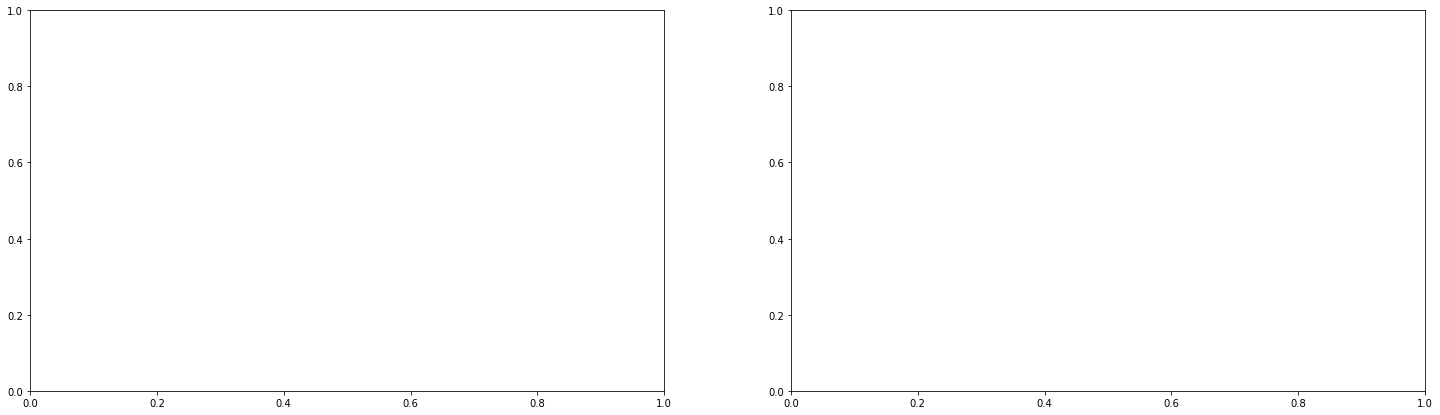

In [21]:
n = 5
def assemble_scores(scores, experimental_sets, idx, score_layer, score_type):
    score_list = []
    for concepts in experimental_sets:
        score_list.append(scores["-".join([str(c.id) for c in concepts])][score_layer][score_type][idx])
        
    return score_list
    
def get_pval(scores, experimental_sets, score_layer, score_type, alpha=0.05, print_ret=False):
    
    P1 = assemble_scores(scores, experimental_sets, 0, score_layer, score_type)
    P2 = assemble_scores(scores, experimental_sets, 1, score_layer, score_type)
    
    if print_ret:
        print('P1[mean, std]: ', format_float(np.mean(P1)), format_float(np.std(P1)))
        print('P2[mean, std]: ', format_float(np.mean(P2)), format_float(np.std(P2)))

    _, pval = ttest_ind(P1, P2)

    if print_ret:
        print("p-values:", format_float(pval))

    if pval < alpha:    # alpha value is 0.05 or 5%
        relation = "Disjoint"
        if print_ret:
            print("Disjoint")
    else:
        relation = "Overlap"
        if print_ret:
            print("Overlap")
        
    return P1, P2, format_float(pval), relation
    
def show_boxplots(layer, metric='sign_count'):

    def format_label_text(experimental_sets):
        concept_id_list = [exp.name if i == 0 else \
                             exp.name.split('_')[0] for i, exp in enumerate(experimental_sets[0])]
        return concept_id_list

    n_plots = 2

    fig, ax = plt.subplots(1, n_plots, figsize = (25, 7 * 1))
    fs = 18
    for i in range(n_plots):
        esl = experimental_sets[i * n : (i+1) * n]
        P1, P2, pval, relation = get_pval(scores, esl, layer, metric)

        ax[i].set_ylim([0, 1])
        ax[i].set_title(layer + "-" + metric + " (pval=" + str(pval) + " - " + relation + ")", fontsize=fs)
        ax[i].boxplot([P1, P2], showfliers=True)

        ax[i].set_xticklabels(format_label_text(esl), fontsize=fs)

    plt.show()

show_boxplots ("arch.layer4")

Below box plots visualize the distribution of TCAV scores for two pairs of concepts in the different layers. Each layer is visualized in a separate jupyter cell. 
Below diagrams show that `striped` concept has TCAV scores that are consistently high across all layers and experimental sets as apposed to `random` concept. It also shows that `striped` and `random` are disjoint populations.

When we compare the populations of two random concepts we see that the p-value is much higher, meaning that those populations overlap and we cannot reject null hypothesis anymore. 

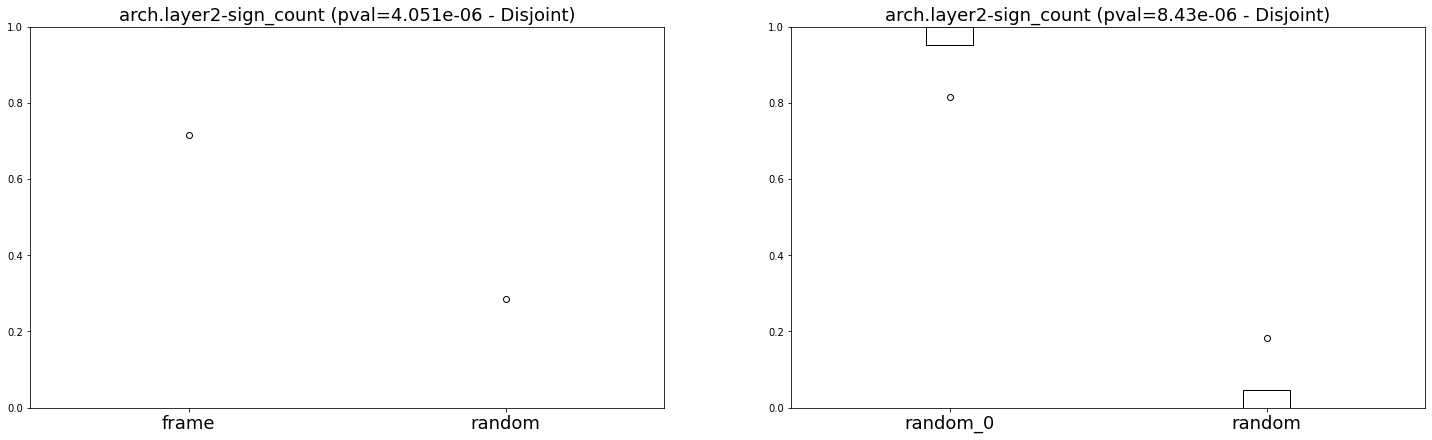

In [ ]:
show_boxplots ("arch.layer2")

KeyError: 'arch.layer3'

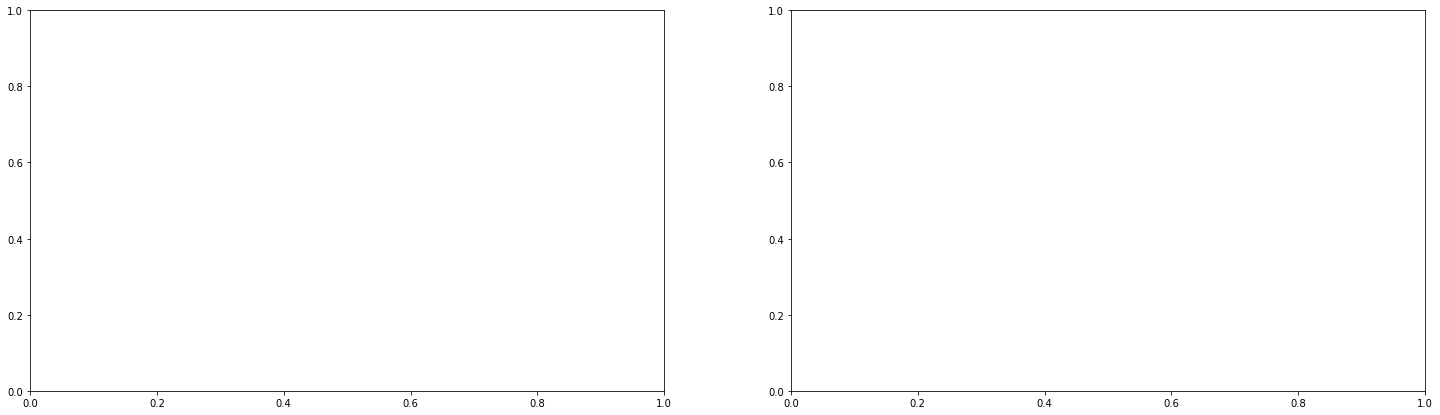

In [23]:
show_boxplots ("arch.layer3")

KeyError: 'arch.layer4'

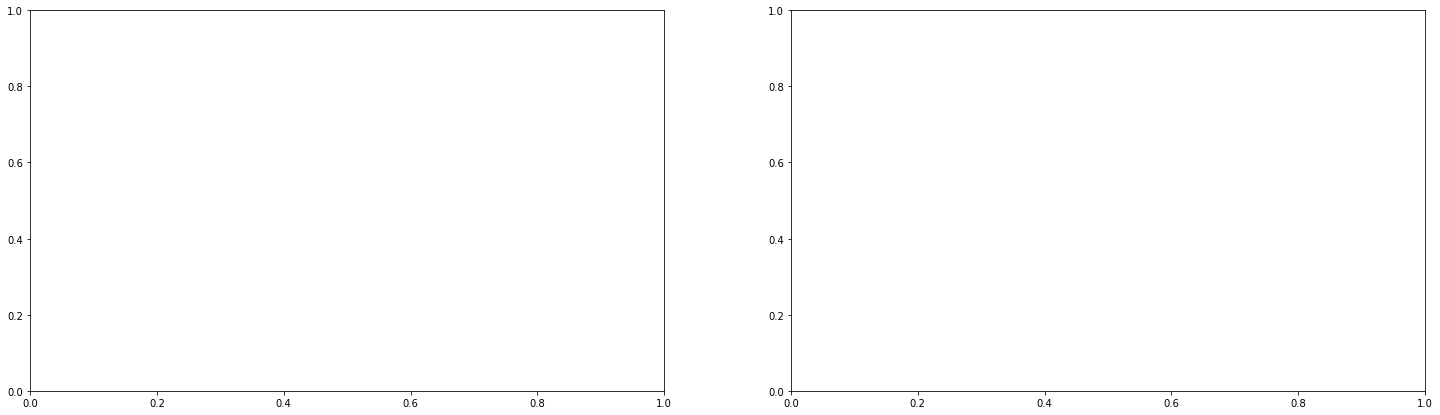

In [22]:
show_boxplots ("arch.layer4")